# Branch 2: Parameter Sensitivity Analysis

## 목적
- 각 모델별 파라미터가 성능에 미치는 영향 분석
- One-at-a-time (OAT) 방식: 한 번에 하나씩 변경
- Heatmap으로 종합 시각화

## 전처리 조건 (고정)
- FD001: Robust Scaler + RUL=100
- FD004: Standard Scaler + RUL=100

# 0. 초기 설정

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from pathlib import Path

# 데이터 처리
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge

# Tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 한글 폰트
import matplotlib.font_manager as fm

font_path = '/content/drive/MyDrive/ML project/NanumGothic-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_name

In [4]:
# 경로
DATA_DIR = Path('/content/drive/MyDrive/ML project/')
TRAIN_FD001 = DATA_DIR / 'train_FD001.txt'
TRAIN_FD004 = DATA_DIR / 'train_FD004.txt'

RESULTS_DIR = Path('/content/drive/MyDrive/ML project/results')
RESULTS_DIR.mkdir(exist_ok=True)

In [ ]:
# 전역 설정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

SENSOR_COLS = [f's_{i}' for i in range(1, 22)]
SETTING_COLS = ['setting_1', 'setting_2', 'setting_3']
TRAIN_RATIO = 0.8

# 전처리 조건 (고정)
PREPROCESSING = {
    'FD001': {'rul_threshold': 100, 'scaling': 'robust'},
    'FD004': {'rul_threshold': 100, 'scaling': 'standard'}
}

# 1. 파라미터 정의

In [ ]:
# Baseline 파라미터

BASELINE_PARAMS = {
    'linear': {
        'alpha': 1e-3
    },
    'xgboost': {
        'max_depth': 4,
        'learning_rate': 0.05,
        'n_estimators': 300
    },
    'lightgbm': {
        'num_leaves': 31,
        'max_depth': -1
    },
    'rf': {
        'max_depth': None,
        'n_estimators': 200
    },
    'lstm': {
        'window_size': 30,
        'units': 64,
        'layers': 2
    },
    'gru': {
        'window_size': 30,
        'units': 64,
        'layers': 2
    },
    'cnn': {
        'filters': 64,
        'kernel_size': 3,
        'layers': 2
    },
    'tcn': {
        'dilations': [1, 2, 4],
        'kernel_size': 3,
        'filters': 64
    }
}

In [ ]:
# 테스트할 파라미터 값들

TEST_PARAMS = {
    'linear': {
        'alpha': [0.0, 0.001, 0.01]
    },
    'xgboost': {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300]
    },
    'lightgbm': {
        'num_leaves': [31, 63, 127],
        'max_depth': [-1, 8, 12]
    },
    'rf': {
        'max_depth': [None, 10, 20],
        'n_estimators': [100, 200, 500]
    },
    'lstm': {
        'window_size': [30, 50, 80],
        'units': [64, 128, 256],
        'layers': [1, 2, 3]
    },
    'gru': {
        'window_size': [30, 50, 80],
        'units': [64, 128, 256],
        'layers': [1, 2, 3]
    },
    'cnn': {
        'filters': [32, 64, 128],
        'kernel_size': [3, 5, 7],
        'layers': [1, 2, 3]
    },
    'tcn': {
        'dilations': [[1, 2], [1, 2, 4], [1, 2, 4, 8]],
        'kernel_size': [2, 3, 5],
        'filters': [32, 64, 128]
    }
}

In [ ]:
# 파라미터 검증 및 수정: TEST_PARAMS의 모든 값이 리스트인지 확인하고, 아니면 리스트로 변환
for model_name in TEST_PARAMS.keys():
    for param_name, param_values in list(TEST_PARAMS[model_name].items()):
        if not isinstance(param_values, list):
            TEST_PARAMS[model_name][param_name] = [param_values]

# 2. 데이터 로딩 및 전처리

In [ ]:
def load_cmapss_data(file_path):
    columns = ['unit', 'cycle'] + SETTING_COLS + SENSOR_COLS
    df = pd.read_csv(file_path, sep='\\s+', header=None, names=columns)

    max_cycles = df.groupby('unit')['cycle'].max().reset_index()
    max_cycles.columns = ['unit', 'max_cycle']
    df = df.merge(max_cycles, on='unit', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df = df.drop('max_cycle', axis=1)

    return df

def split_by_units(df, train_ratio=0.8, seed=42):
    np.random.seed(seed)
    all_units = df['unit'].unique()
    shuffled_units = np.random.permutation(all_units)
    n_train = int(len(all_units) * train_ratio)

    train_units = shuffled_units[:n_train]
    test_units = shuffled_units[n_train:]

    train_df = df[df['unit'].isin(train_units)].copy()
    test_df = df[df['unit'].isin(test_units)].copy()

    return train_df, test_df

def apply_rul_clipping(df, threshold=100):
    df = df.copy()
    df['RUL'] = df['RUL'].clip(upper=threshold)
    return df

def apply_scaling(df, feature_cols, scaler_type='robust'):
    df = df.copy()
    for unit in df['unit'].unique():
        mask = df['unit'] == unit
        if scaler_type == 'robust':
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        df.loc[mask, feature_cols] = scaler.fit_transform(df.loc[mask, feature_cols])
    return df

def create_sequences(df, feature_cols, window_size=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_data = df[df['unit'] == unit].sort_values('cycle')
        features = unit_data[feature_cols].values
        targets = unit_data['RUL'].values

        for i in range(len(features) - window_size + 1):
            X.append(features[i:i+window_size])
            y.append(targets[i+window_size-1])

    return np.array(X), np.array(y)

# 데이터 로딩
train_fd001 = load_cmapss_data(TRAIN_FD001)
train_fd004 = load_cmapss_data(TRAIN_FD004)

# 3. 모델 생성 함수

In [ ]:
def create_model(model_name, params, input_shape=None):
    if model_name == 'linear':
        return Ridge(alpha=params['alpha'], random_state=SEED)

    elif model_name == 'xgboost':
        return xgb.XGBRegressor(
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            random_state=SEED,
            n_jobs=-1
        )

    elif model_name == 'lightgbm':
        return lgb.LGBMRegressor(
            num_leaves=params['num_leaves'],
            max_depth=params['max_depth'],
            learning_rate=0.05,
            n_estimators=200,
            random_state=SEED,
            n_jobs=-1,
            verbose=-1
        )

    elif model_name == 'rf':
        return RandomForestRegressor(
            max_depth=params['max_depth'],
            n_estimators=params['n_estimators'],
            random_state=SEED,
            n_jobs=-1
        )

    elif model_name == 'lstm':
        inputs = Input(shape=input_shape)
        x = inputs

        for i in range(params['layers']):
            return_sequences = (i < params['layers'] - 1)
            x = layers.LSTM(params['units'], return_sequences=return_sequences)(x)
            x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(1)(x)
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

    elif model_name == 'gru':
        inputs = Input(shape=input_shape)
        x = inputs

        for i in range(params['layers']):
            return_sequences = (i < params['layers'] - 1)
            x = layers.GRU(params['units'], return_sequences=return_sequences)(x)
            x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(1)(x)
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

    elif model_name == 'cnn':
        inputs = Input(shape=input_shape)
        x = inputs

        for i in range(params['layers']):
            x = layers.Conv1D(params['filters'], params['kernel_size'],
                            activation='relu', padding='same')(x)
            x = layers.MaxPooling1D(2)(x)
            x = layers.Dropout(0.2)(x)

        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

    elif model_name == 'tcn':
        inputs = Input(shape=input_shape)
        x = inputs

        for dilation in params['dilations']:
            x = layers.Conv1D(params['filters'], params['kernel_size'],
                            dilation_rate=dilation, activation='relu',
                            padding='causal')(x)
            x = layers.Dropout(0.2)(x)

        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

In [ ]:
# 데이터 저장 구조

# 학습 곡선 저장 (DL 모델)
histories = {}

# 예측값 저장 (에러 분석용)
predictions = {}

# 결과 저장
results = {
    'FD001': {},
    'FD004': {}
}


# 4. 파라미터 민감도 실험

In [ ]:
for dataset_name in ['FD001', 'FD004']:
    # 데이터 준비
    data = train_fd001 if dataset_name == 'FD001' else train_fd004
    prep_config = PREPROCESSING[dataset_name]

    # 전처리
    data = apply_rul_clipping(data, prep_config['rul_threshold'])
    data = apply_scaling(data, SENSOR_COLS, prep_config['scaling'])

    # Split
    train_df, test_df = split_by_units(data, TRAIN_RATIO, SEED)

    results[dataset_name] = {}

    # 모델별 실험
    for model_name in TEST_PARAMS.keys():
        print(f"\n{model_name.upper()} 파라미터 분석...")
        results[dataset_name][model_name] = {}
        baseline_params = BASELINE_PARAMS[model_name].copy()

        # 각 파라미터별로 실험
        for param_name, param_values in TEST_PARAMS[model_name].items():
            print(f"  - {param_name}: {param_values}")
            results[dataset_name][model_name][param_name] = {}

            # param_values가 리스트인지 확인
            if not isinstance(param_values, list):
                param_values = [param_values]

            for param_value in param_values:
                try:
                    # 파라미터 설정
                    params = baseline_params.copy()
                    params[param_name] = param_value

                    # 시퀀스 생성 (window_size 변경 시)
                    if param_name == 'window_size':
                        window_size = param_value
                    else:
                        window_size = params.get('window_size', 30)

                    X_train, y_train = create_sequences(train_df, SENSOR_COLS, window_size)
                    X_test, y_test = create_sequences(test_df, SENSOR_COLS, window_size)

                    # 모델 학습
                    if model_name in ['linear', 'xgboost', 'lightgbm', 'rf']:
                        X_train_flat = X_train.reshape(X_train.shape[0], -1)
                        X_test_flat = X_test.reshape(X_test.shape[0], -1)

                        model = create_model(model_name, params)
                        model.fit(X_train_flat, y_train)
                        y_pred = model.predict(X_test_flat)

                    else:  # DL models
                        input_shape = (window_size, len(SENSOR_COLS))
                        model = create_model(model_name, params, input_shape)

                        model.fit(
                            X_train, y_train,
                            validation_split=0.2,
                            epochs=50,
                            batch_size=64,
                            callbacks=[
                                EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(patience=5, factor=0.5)
                            ],
                            verbose=0
                        )
                        y_pred = model.predict(X_test, verbose=0).flatten()

                    # 학습 곡선 저장 (DL 모델)
                    history_key = None
                    if model_name not in ['linear', 'xgboost', 'lightgbm', 'rf']:
                        history_key = f'{dataset_name}_{model_name}_{param_name}_{param_value}'
                        if history_key not in histories:
                            histories[history_key] = {
                                'loss': model.history.history.get('loss', []),
                                'val_loss': model.history.history.get('val_loss', [])
                            }

                    # 평가
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)

                    # 예측값 저장 (상세 분석용)
                    pred_key = f'{dataset_name}_{model_name}_{param_name}_{param_value}'
                    predictions[pred_key] = {
                        'y_true': y_test,
                        'y_pred': y_pred
                    }

                    results[dataset_name][model_name][param_name][str(param_value)] = {
                        'rmse': float(rmse),
                        'mae': float(mae)
                    }

                except Exception as e:
                    pred_key = f'{dataset_name}_{model_name}_{param_name}_{param_value}'
                    predictions[pred_key] = {
                        'y_true': y_test,
                        'y_pred': y_pred
                    }

                    results[dataset_name][model_name][param_name][str(param_value)] = {
                        'rmse': np.nan,
                        'mae': np.nan
                    }

# 5. 결과 저장

In [ ]:
# JSON 저장
with open(RESULTS_DIR / 'parameter_sensitivity_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# 6. 모델 계열별 성능 비교

## JSON/CSV 파일에서 결과 로드하여 시각화

In [5]:
# JSON 파일 경로
PARAM_RESULTS_PATH = RESULTS_DIR / 'parameter_sensitivity_results.json'
BASELINE_RESULTS_PATH = RESULTS_DIR / 'results_by_conditions.json'
CSV_PATH = RESULTS_DIR / 'parameter_sensitivity_table.csv'

# 1. Baseline 결과
with open(BASELINE_RESULTS_PATH, 'r') as f:
    baseline_results = json.load(f)

# 2. 파라미터 민감도 결과
with open(PARAM_RESULTS_PATH, 'r') as f:
    param_results = json.load(f)


## BASELINE 파라미터로 각 모델 계열 비교

In [6]:
MODEL_FAMILIES = {
    'Linear': ['linear'],
    'Tree-based': ['xgboost', 'lightgbm', 'rf'],
    'RNN': ['lstm', 'gru'],
    'CNN': ['cnn', 'tcn']
}

# 계열별 색상
FAMILY_COLORS = {
    'Linear': '#7B9FCC',
    'Tree-based': '#7DBF8E',
    'RNN': '#D17B7B',
    'CNN': '#9D8FCC'
}

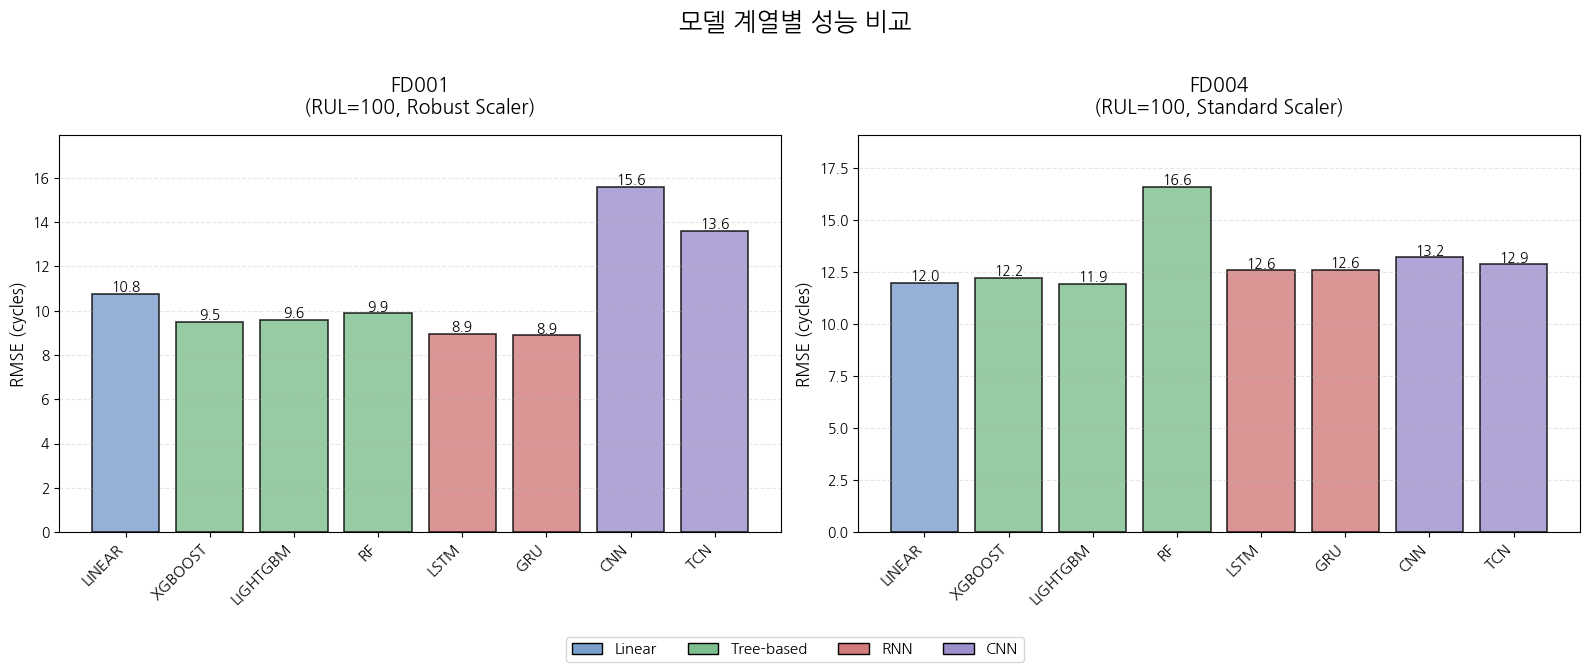

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('모델 계열별 성능 비교', fontsize=18, fontweight='bold', y=1.02)

for idx, dataset_name in enumerate(['FD001', 'FD004']):
    ax = axes[idx]

    models = []
    rmse_values = []
    colors = []

    # 각 계열별로 모델 순회
    for family, family_models in MODEL_FAMILIES.items():
        for model_name in family_models:
            # 올바른 접근: baseline_results[dataset_name][dataset_name][model_name]
            if model_name in baseline_results[dataset_name][dataset_name]:
                rmse = baseline_results[dataset_name][dataset_name][model_name]['rmse']
                models.append(model_name.upper())
                rmse_values.append(rmse)
                colors.append(FAMILY_COLORS[family])

    # 막대 그래프
    bars = ax.bar(range(len(models)), rmse_values, color=colors,
                  edgecolor='black', linewidth=1.2, alpha=0.8)

    # 값 표시
    for i, (bar, value) in enumerate(zip(bars, rmse_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{value:.1f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

    scaler = 'Robust Scaler' if dataset_name == 'FD001' else 'Standard Scaler'

    ax.set_title(f'{dataset_name}\n(RUL=100, {scaler})',
                fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('RMSE (cycles)', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    if rmse_values:
        ax.set_ylim(0, max(rmse_values) * 1.15)

# 범례
legend_elements = [
    plt.Rectangle((0,0),1,1, fc=FAMILY_COLORS['Linear'],
                 edgecolor='black', linewidth=1, label='Linear'),
    plt.Rectangle((0,0),1,1, fc=FAMILY_COLORS['Tree-based'],
                 edgecolor='black', linewidth=1, label='Tree-based'),
    plt.Rectangle((0,0),1,1, fc=FAMILY_COLORS['RNN'],
                 edgecolor='black', linewidth=1, label='RNN'),
    plt.Rectangle((0,0),1,1, fc=FAMILY_COLORS['CNN'],
                 edgecolor='black', linewidth=1, label='CNN')
]

fig.legend(handles=legend_elements, loc='lower center',
          ncol=4, fontsize=11, frameon=True, bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
plt.show()

# 7. 상세 시각화 분석

In [12]:
def plot_param_sensitivity_from_json(model_name):
    # 두 데이터셋 모두에서 해당 모델의 파라미터 추출
    model_data_fd001 = param_results['FD001'][model_name]
    model_data_fd004 = param_results['FD004'][model_name]

    # Baseline RMSE
    baseline_rmse_fd001 = baseline_results['FD001']['FD001'][model_name]['rmse']
    baseline_rmse_fd004 = baseline_results['FD004']['FD004'][model_name]['rmse']

    # 파라미터 개수 (FD001 기준, 둘이 동일하다고 가정)
    param_names = list(model_data_fd001.keys())
    n_params = len(param_names)

    # 각 파라미터별로 Figure 생성
    for param_name in param_names:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        fig.suptitle(
            f'{model_name.upper()}: {param_name} 파라미터 민감도 분석',
            fontsize=16,
            fontweight='bold',
            y=1.02
        )

        datasets = ['FD001', 'FD004']
        baselines = [baseline_rmse_fd001, baseline_rmse_fd004]
        model_datas = [model_data_fd001, model_data_fd004]

        for idx, (dataset, baseline_rmse, model_data) in enumerate(zip(datasets, baselines, model_datas)):
            ax = axes[idx]

            # 해당 파라미터 데이터 추출
            param_data = model_data[param_name]

            # 데이터 추출
            param_values = []
            rmse_values = []
            mae_values = []

            for value, metrics in param_data.items():
                param_values.append(value)
                rmse_values.append(metrics['rmse'])
                mae_values.append(metrics['mae'])

            # X축 위치
            x = range(len(param_values))

            # RMSE 플롯
            ax.plot(x, rmse_values, marker='o', linewidth=2.5, markersize=5, label='RMSE', color='#7B9FCC')

            # MAE 플롯
            ax2 = ax.twinx()
            ax2.plot(x, mae_values, marker='s', linewidth=2.5, markersize=5, label='MAE', color='#7DBF8E')

            # 제목 및 레이블
            ax.set_title(f'{dataset}', fontsize=14, fontweight='bold', pad=15)
            ax.set_xlabel('파라미터 값', fontsize=12, fontweight='bold')
            ax.set_ylabel('RMSE (cycles)', fontsize=12, fontweight='bold', color='#7B9FCC')
            ax2.set_ylabel('MAE (cycles)', fontsize=12, fontweight='bold', color='#7DBF8E')

            # X축 틱
            ax.set_xticks(x)
            formatted_labels = []
            for val in param_values:
                try:
                    # 숫자로 변환 가능하면 소수점 둘째자리까지
                    num_val = float(val)
                    formatted_labels.append(f'{num_val:.2f}')
                except (ValueError, TypeError):
                    # 변환 불가능하면 그대로 표시
                    formatted_labels.append(str(val))
            ax.set_xticklabels(formatted_labels, rotation=45, ha='right', fontsize=11)

            # 틱 색상
            ax.tick_params(axis='y', labelcolor='#7B9FCC', labelsize=11)
            ax2.tick_params(axis='y', labelcolor='#7DBF8E', labelsize=11)

            # 그리드
            ax.grid(True, alpha=0.3, linestyle='--')

            # 범례
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2,
                     loc='upper right', fontsize=10, framealpha=0.9)

        plt.tight_layout()
        plt.show()

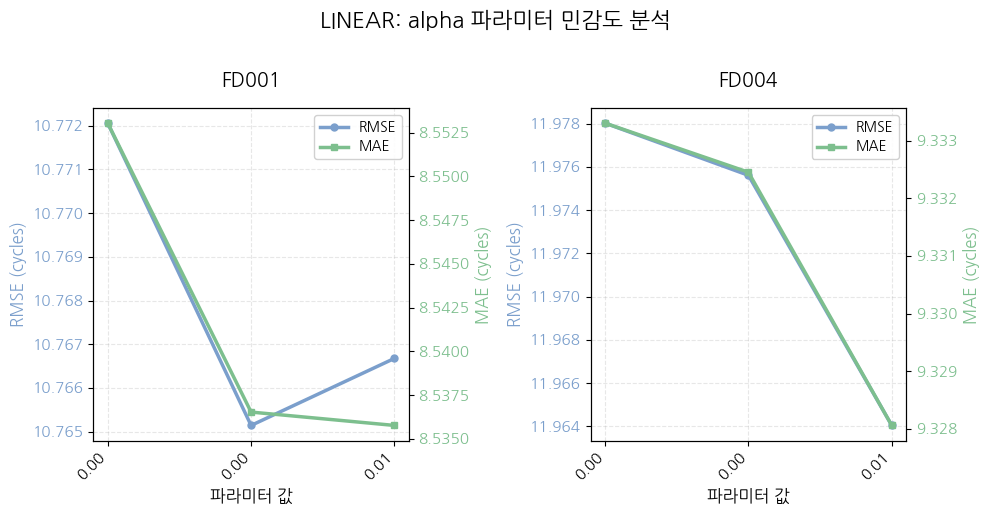

In [13]:
plot_param_sensitivity_from_json('linear')


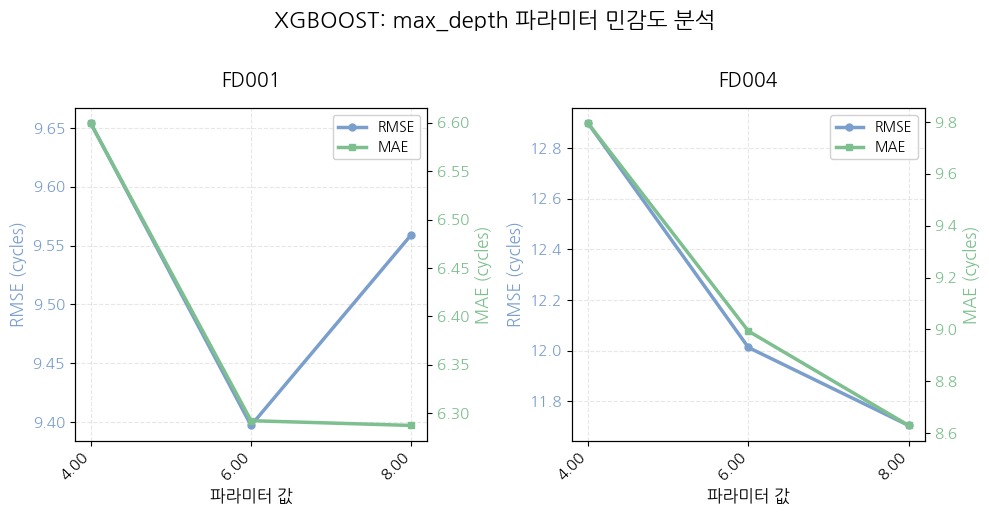

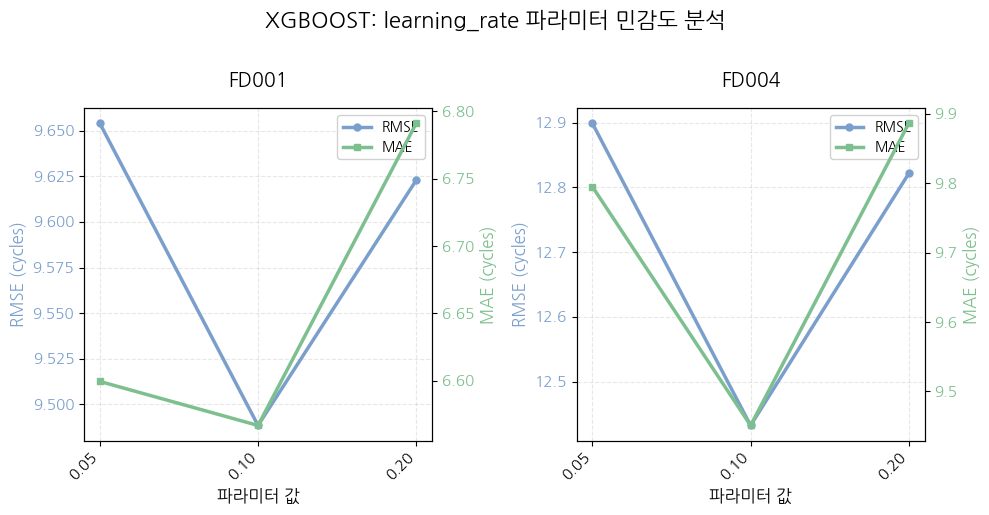

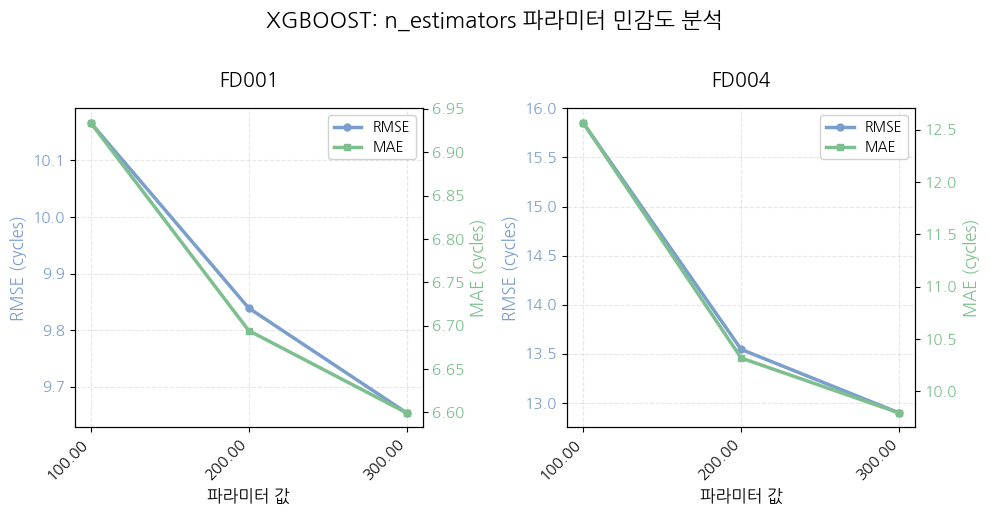

In [14]:
plot_param_sensitivity_from_json('xgboost')

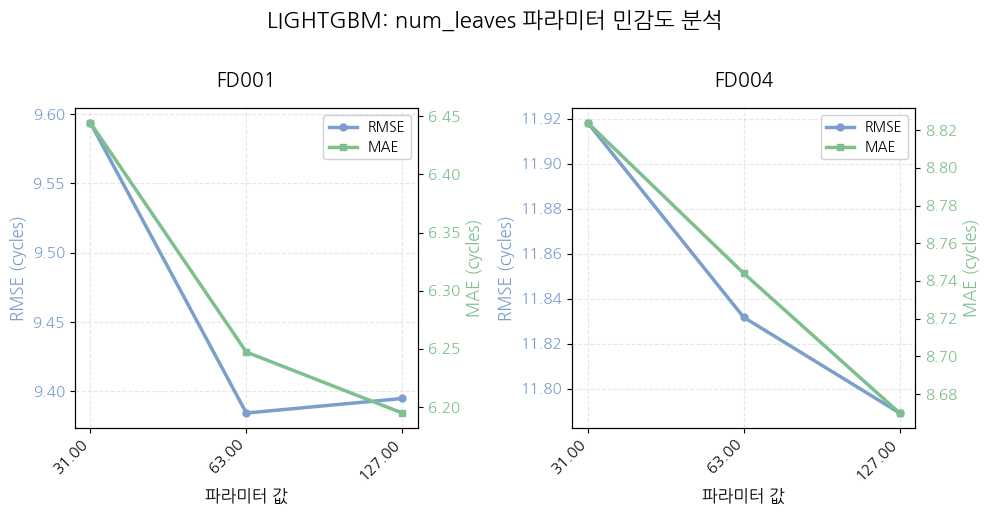

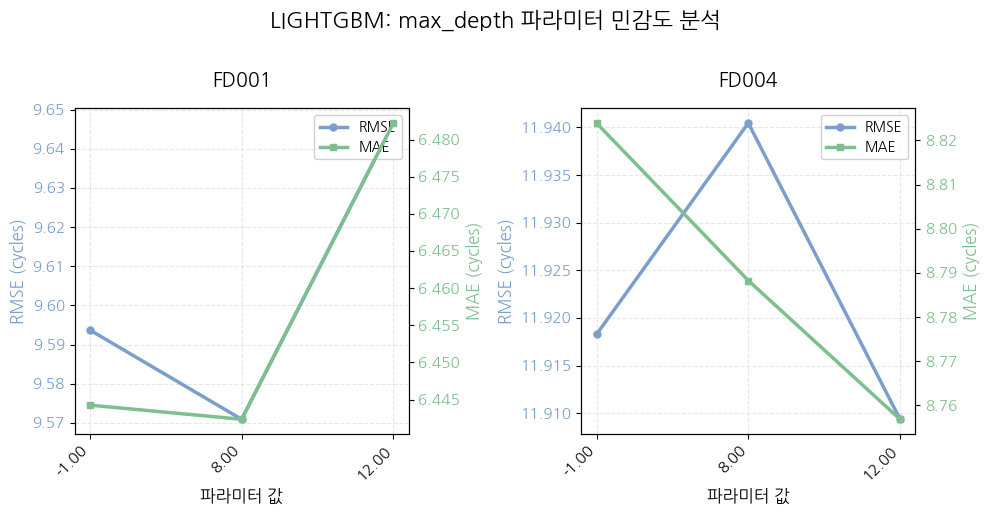

In [15]:
plot_param_sensitivity_from_json('lightgbm')

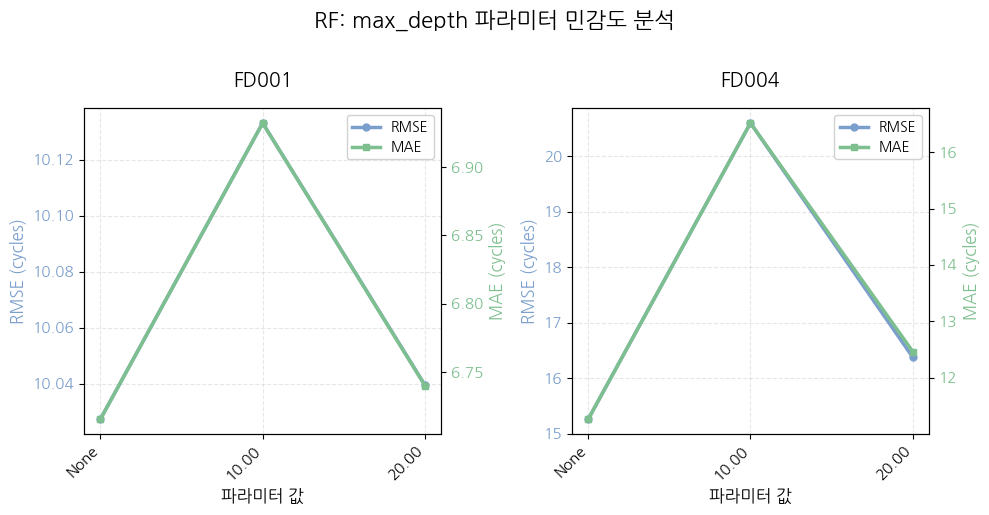

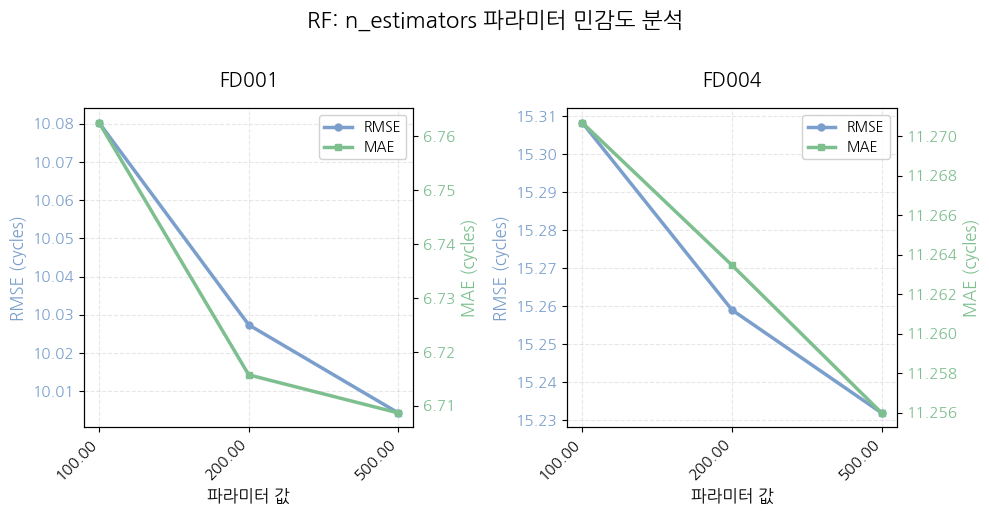

In [16]:
plot_param_sensitivity_from_json('rf')

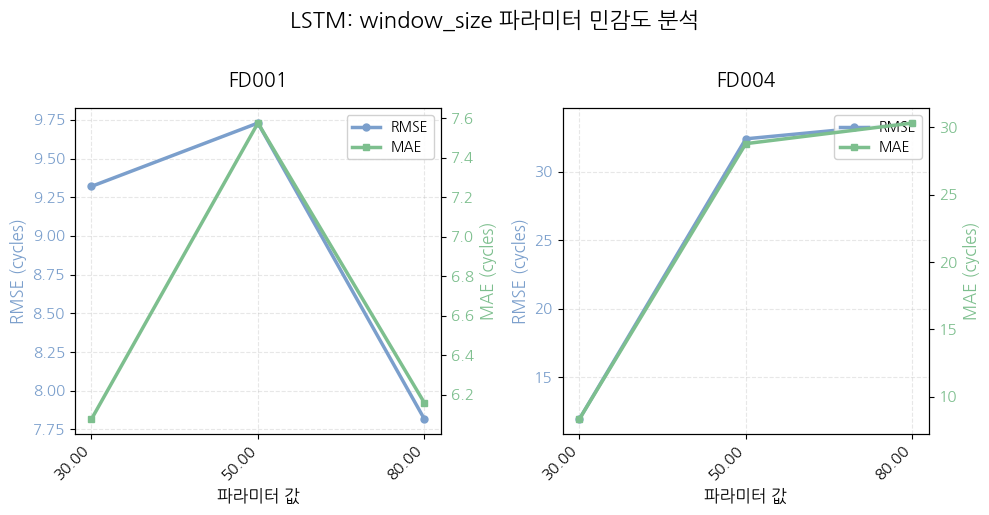

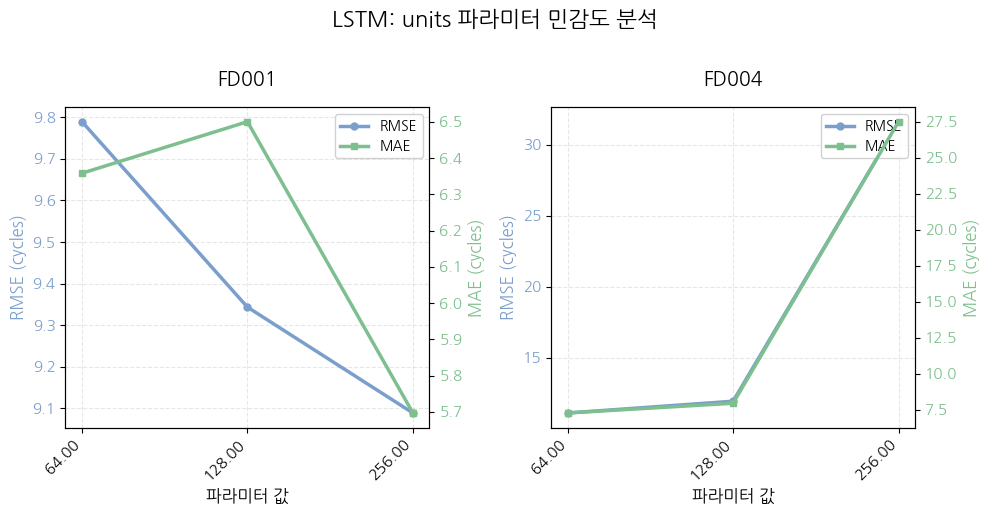

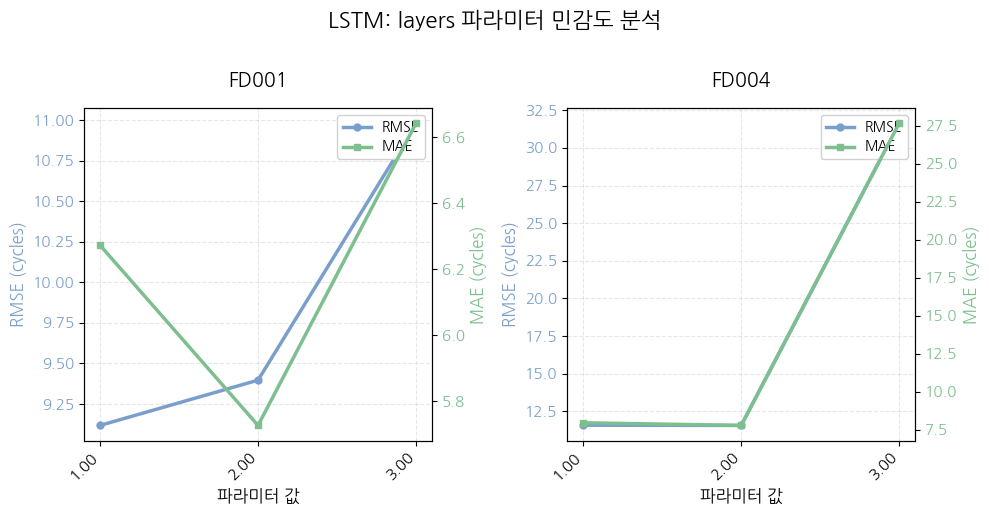

In [17]:
plot_param_sensitivity_from_json('lstm')

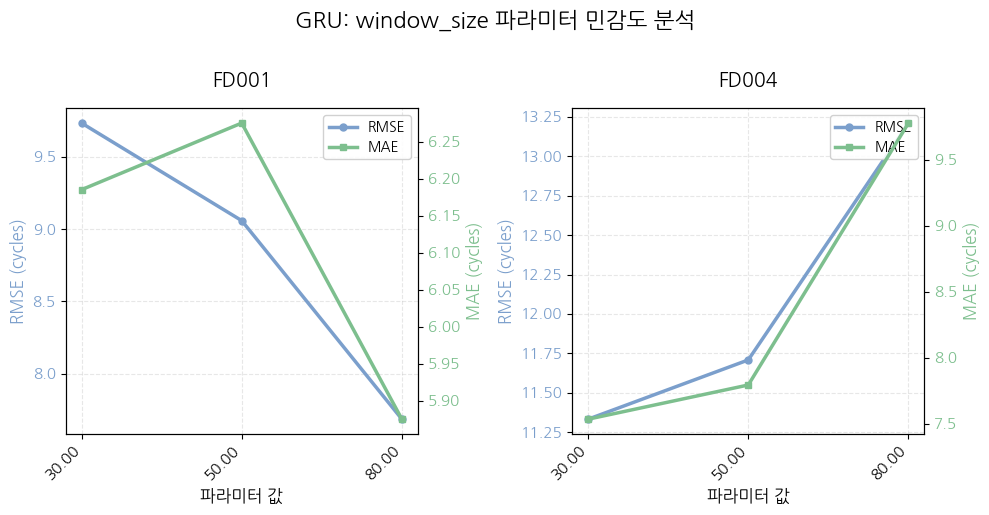

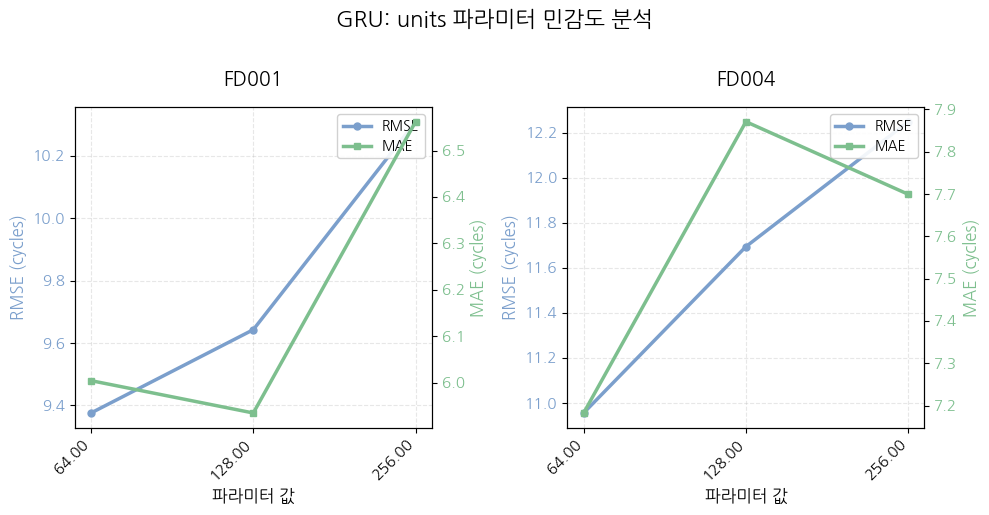

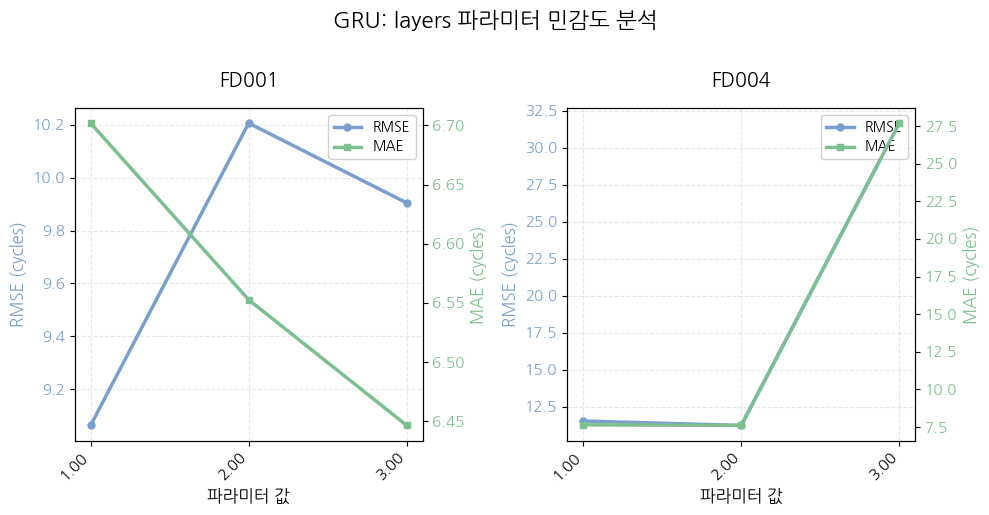

In [18]:
plot_param_sensitivity_from_json('gru')

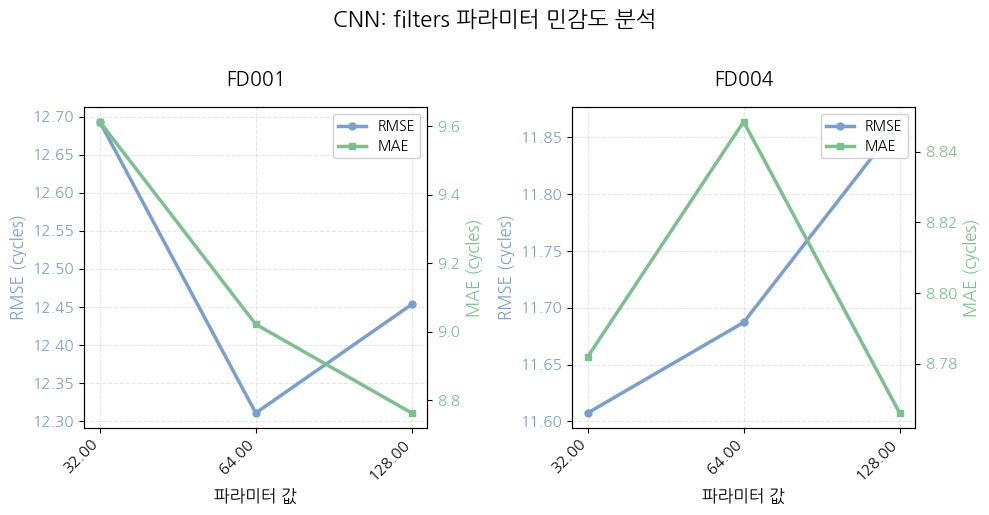

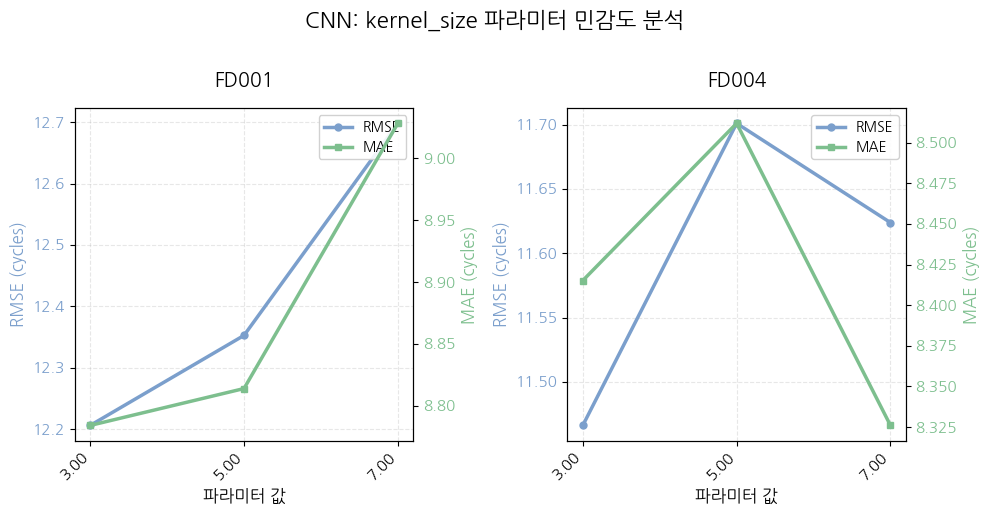

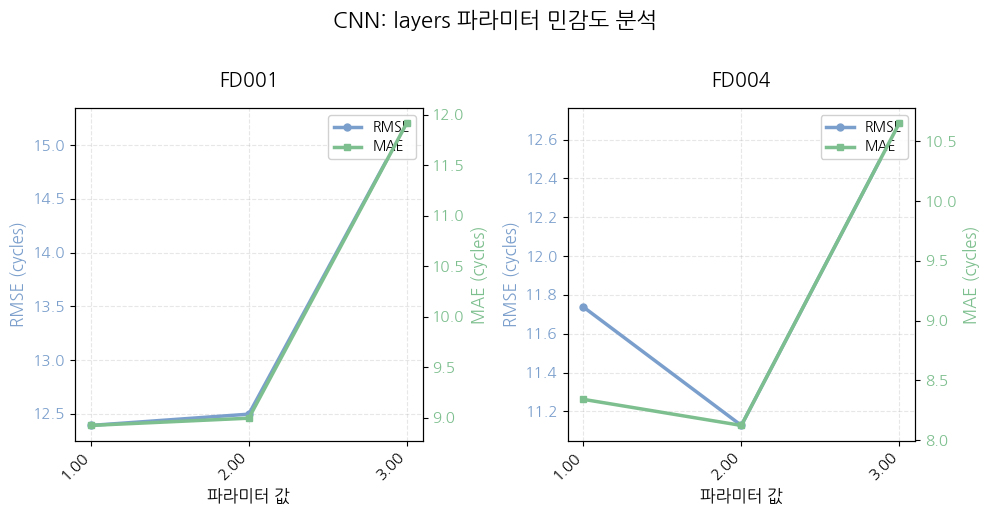

In [19]:
plot_param_sensitivity_from_json('cnn')

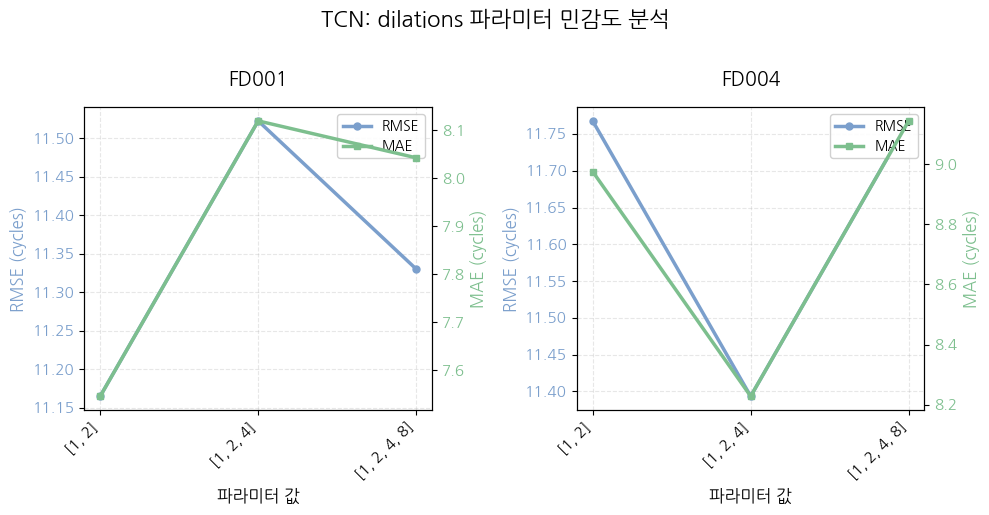

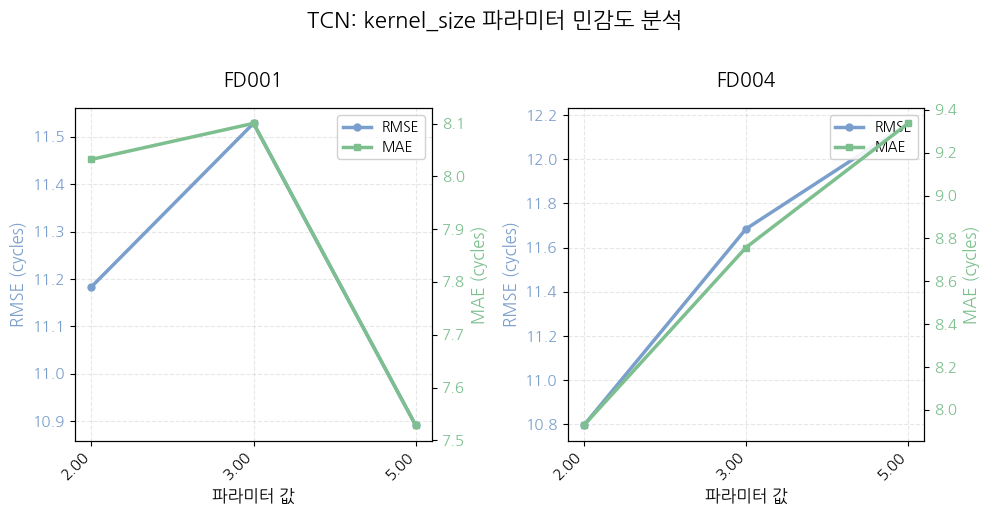

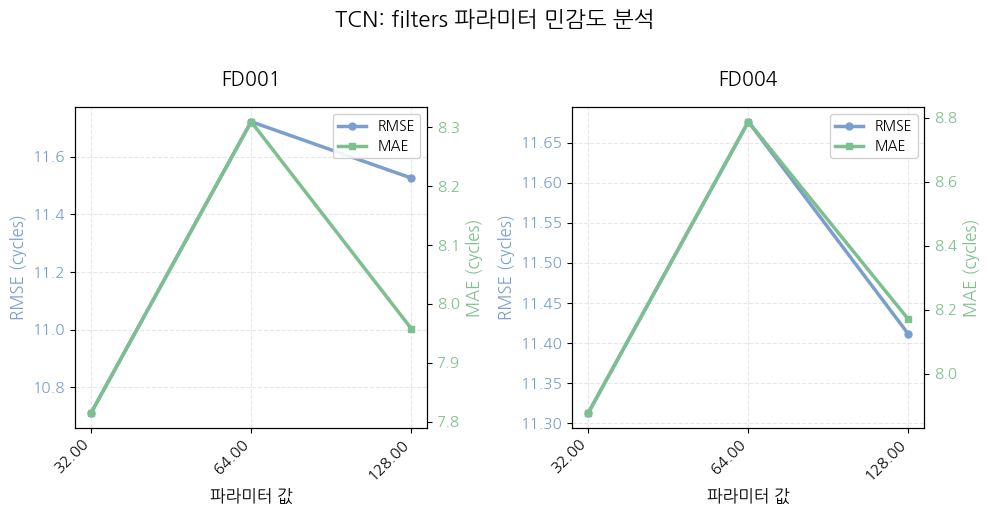

In [20]:
plot_param_sensitivity_from_json('tcn')